<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

В нашем проекте компания «Чётенькое такси» стремится улучшить эффективность работы в аэропортах, используя исторические данные о заказах. Основная задача — построить модель и спрогнозировать количество заказов такси на следующий час, чтобы привлечь больше водителей в периоды пиковой нагрузки.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders.

Для достижения нашей цели нам необходимо:  

 1) Загрузить данные и ресемплировать их по одному часу.  
 2) Провести анализ данных.   
 3) Обучить различные модели с настройкой гиперпараметров, выделив 10% данных для тестовой выборки.   
 4) Оценить модели по качеству на тренировочной выборке, а также по времени обучения и предсказания, определить наилучшую модель и, после её выбора, рассчитать RMSE на тестовой выборке, обеспечив, чтобы метрика RMSE не превышала 48.

Следуя этим шагам, мы сможем разработать модель машинного обучения для прогнозирования количества заказов такси в аэропортах на следующий час, которая позволит более точно привлекать водителей в периоды высокого спроса, обеспечивая их присутствие в нужное время и место.

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik
!pip install statsmodels
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb
import phik
import warnings
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, GridSearchCV, TimeSeriesSplit)
from sklearn.metrics import (mean_squared_error, roc_auc_score)
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
MAX_LAG = 24
ROLLING_MEAN_SIZE = 24

Для начала загрузим наш исходный датасет

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
display(taxi.head(5))
display(taxi.tail(5))
taxi.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Для начала проверим, есть ли пропуски в нашем датасете

In [4]:
taxi.isna().sum()

datetime      0
num_orders    0
dtype: int64

Также изменим тип данных столбца datetime с object на datetime64.

In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [6]:
taxi.set_index('datetime', verify_integrity=True, inplace=True)

Стоблец datetime исчез и наша таблица теперь выглядит так

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Как видно из таблиц выше, у нас имеются данные с 01 марта 2018 по 31 августа 2018 года. Записи идут с промежутком в 10 минут.  
Дополнительно проверим, в хронологическом ли порядке расположены даты и время в датасете

In [8]:
taxi.sort_index(inplace=True)
taxi.index.is_monotonic

True

Т.к. атрибут вернул нам значение True, то порядок соблюдён

In [9]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Как видно отрицательных значений заказов нет. Минимальное количество заказов - 0, среднее количество заказов - 14, а максимальное количество заказов - 119

Выполним ресемплирование. Выберем интервал в один час, а по каждой группе — вычислим суммарное значение.

In [10]:
taxi_res = taxi.resample('1H').sum()

В первой части работы мы успешно подготовили данные для анализа. Изначально датасет состоял из двух столбцов: datetime и num_orders. Мы изменили тип данных datetime с object на datetime64, что позволило преобразовать данные во временной ряд. После этого столбец datetime стал индексом, и таблица теперь содержит только один столбец – num_orders, пропуски в нем отсутствуют. Данные охватывают период с 1 марта по 31 августа 2018 года с интервалом записей в 10 минут. Проведена проверка на монотонность временного ряда. Проверка подтвердила, что даты и время в датасете расположены в хронологическом порядке. Для дальнейшего анализа мы выполнили ресемплирование с интервалом в один час, суммируя значения в каждой группе. Итак, наш датасет подготовлен для следующего этапа анализа.

## Анализ

 Построим наш временной ряд количества заказов такси с марта по август 2018 года

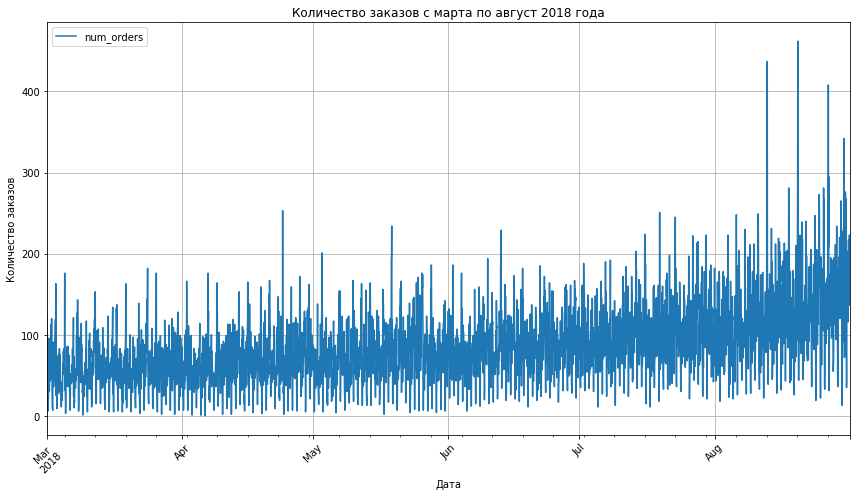

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
taxi_res.plot(ax=ax, linestyle='-', title='Количество заказов с марта по август 2018 года')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Временной ряд на графике демонстрирует значительные колебания из-за изменения среднего значения, поэтому для его сглаживания применим скользящее среднее.

In [12]:
taxi_res['rolling_mean']=taxi_res.rolling(window=25).mean()

Мы выбрали скользящее среднее с окном в 24 наблюдения, чтобы уменьшить колебания временного ряда и сделать более явными основные тренды и сезонные паттерны в данных.

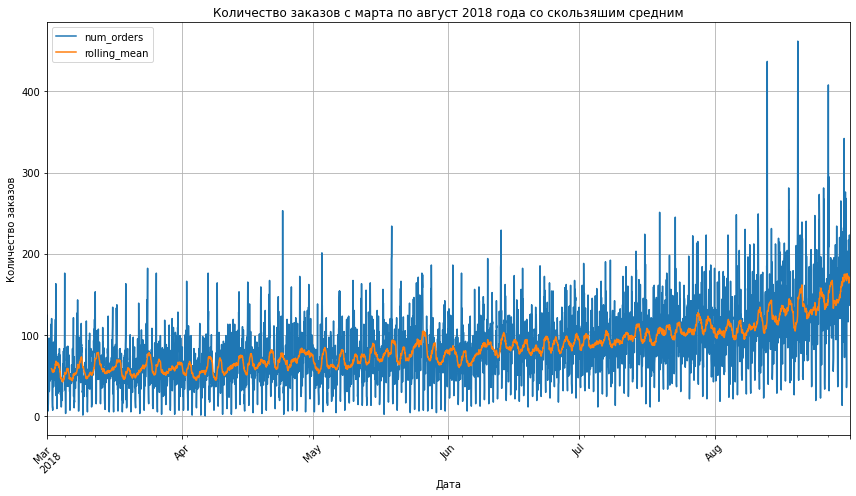

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
taxi_res.plot(ax=ax, linestyle='-', title='Количество заказов с марта по август 2018 года со скользяшим средним')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ряд выглядит нестационарным, поэтому давайте проверим, являются ли разности временного ряда стационарными. Это позволит нам лучше понять характеристики временного ряда и определить, требуется ли дальнейшая обработка для достижения стационарности.

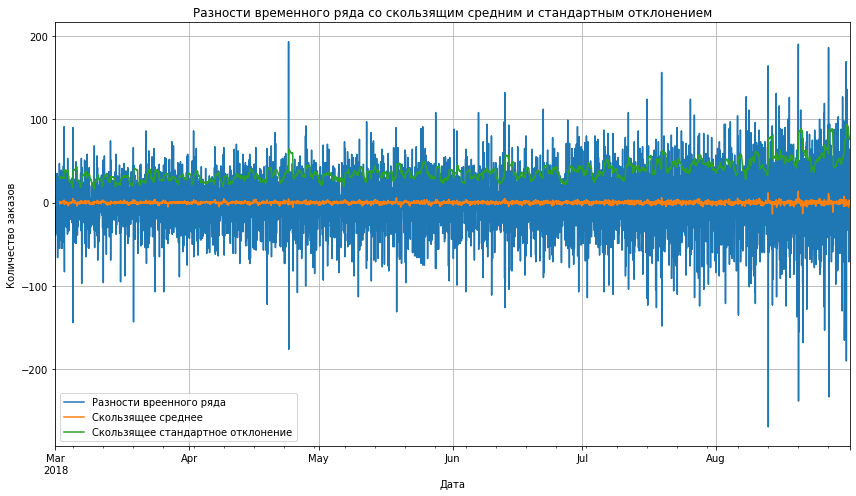

In [14]:
taxi_res_new = taxi_res.copy()
taxi_res_new['num_orders_shifted'] = taxi_res_new['num_orders'] - taxi_res['num_orders'].shift()
taxi_res_new['rolling_mean'] = taxi_res_new['num_orders_shifted'].rolling(24).mean()
taxi_res_new['rolling_std'] = taxi_res_new['num_orders_shifted'].rolling(24).std()

fig, ax = plt.subplots(figsize=(12, 7))
taxi_res_new['num_orders_shifted'].plot(ax=ax, label='Разности вреенного ряда')
taxi_res_new['rolling_mean'].plot(ax=ax, label='Скользящее среднее')
taxi_res_new['rolling_std'].plot(ax=ax, label='Скользящее стандартное отклонение')
plt.legend()
plt.title('Разности временного ряда со скользящим средним и стандартным отклонением')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.tight_layout()
plt.show()

Как мы видим по графику выше, наш ряд стал более стационарным. Среднее значение и стандарное отклонение стали более постоянными и равномерными во времени.

Также, построим графики тренда, сезонности и остатков, чтобы далее мы смогли проанализировать наши данные.

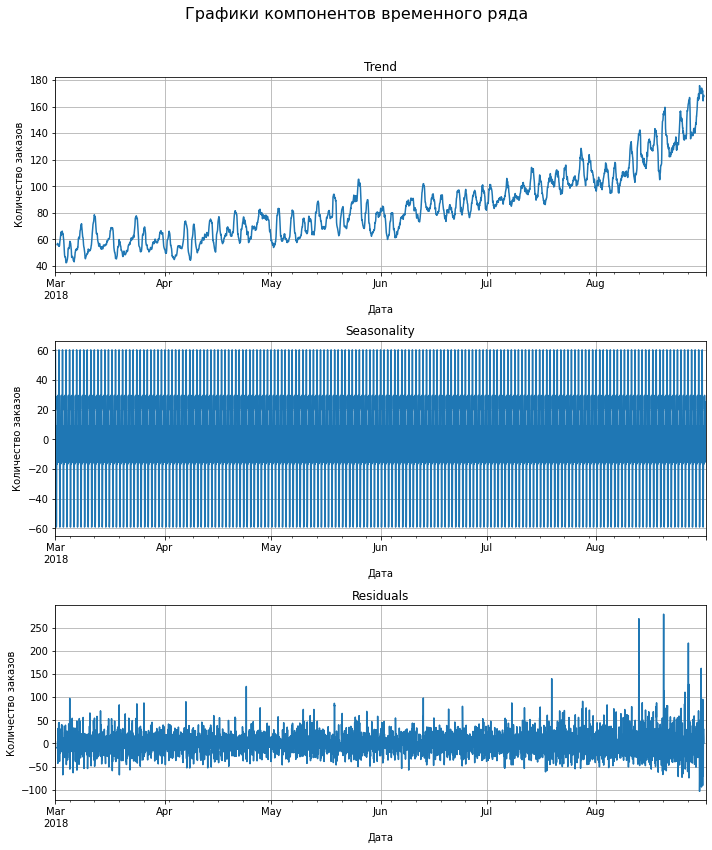

In [15]:
decomposed = seasonal_decompose(taxi_res['num_orders'])

# Создание графиков
plt.figure(figsize=(10, 12))

# Тренд
plt.subplot(3, 1, 1)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

# Сезонность
plt.subplot(3, 1, 2)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

# Остатки
plt.subplot(3, 1, 3)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.suptitle('Графики компонентов временного ряда', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Тренд показывает равномерный рост числа заказов такси с небольшими периодическими снижениями. Это может свидетельствовать о постепенном росте спроса или развитии бизнеса в данной сфере. Далее еще построим график тренда на меньший интервал времени.
- Интерпретировать сезонность на таком длительном диапазоне данных затруднительно, поэтому далее рассмотрим её на более коротком временном отрезке, например, в пределах одной недели или месяца. Это позволит лучше выявить ежедневные колебания и паттерны, связанные с конкретными событиями или днями недели.
- Значительные колебания на графике остатков, вероятно, указывают на присутствие пиковых значений. Эти пики могут быть связаны с внешними факторами, такими как праздничные дни или события, влияющие на спрос на такси.

Для начала давайте рассмотрим тренд на промежутке в 1 месяц (март), чтобы более детально понять, как изменяется количество заказов в этом периоде. На таком небольшом временном отрезке легче заметить основные изменения в заказах такси.

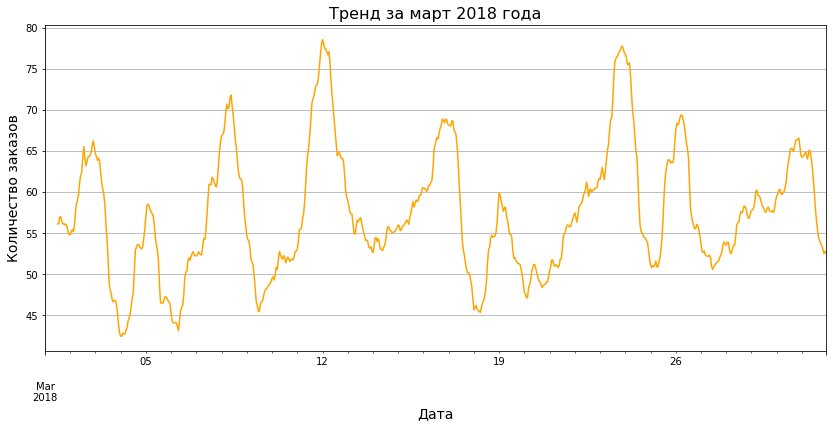

In [16]:
trend_mar = decomposed.trend['2018-03-01':'2018-03-31']
fig, ax = plt.subplots(figsize=(14, 6))
trend_mar.plot(ax=ax, color='orange', grid=True)
ax.set_title('Тренд за март 2018 года', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество заказов', fontsize=14)

plt.show()

Как видно из графика, больше всего такси заказывают по понедельникам и субботам, а меньше всего по воскресеньям и вторникам.

Посмотрим на сезонность для первой недели марта. 1 марта 2018 это четверг, поэтому при рассмотрении недели, мы укажем даты с понедельника по воскресение, то есть с 5 марта по 11 марта.

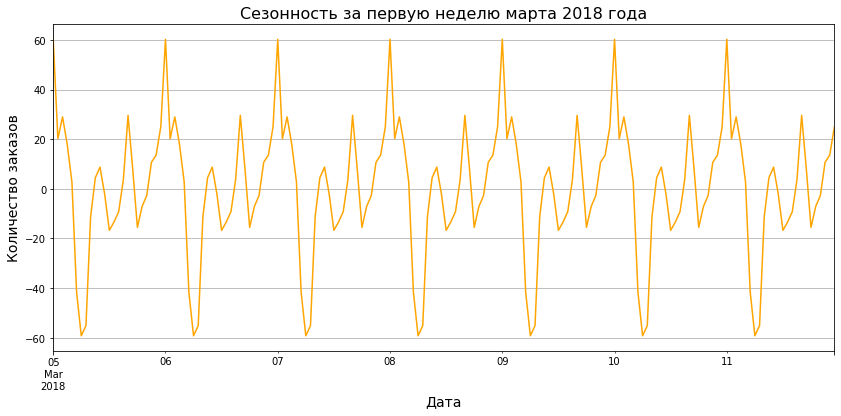

In [17]:
seasonal_week = decomposed.seasonal['2018-03-05':'2018-03-11']
fig, ax = plt.subplots(figsize=(14, 6))
seasonal_week.plot(ax=ax, color='orange', grid=True)
ax.set_title('Сезонность за первую неделю марта 2018 года', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество заказов', fontsize=14)

plt.show()

Мы наблюдаем, что сезонность остается постоянной на протяжении всей недели. В начале каждых суток фиксируется пик заказов, после чего происходит резкое снижение. Затем в течение дня количество заказов увеличивается, достигая нового пика к концу суток.

Как видно, время суток сильно влияет на активность заказов такси. Чтобы удостовериться в этом наблюдении, рассмотрим понедельник 12 марта, так как именно в этот день отмечается наибольшее количество заказов за месяц.

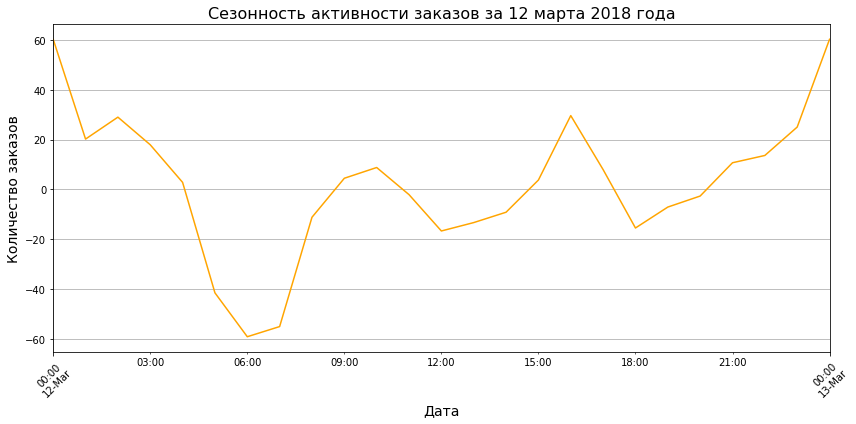

In [18]:
# Построение сезонности активности заказов за 12 марта 2018 года
fig, ax = plt.subplots(figsize=(12, 6))

# 12 марта
decomposed.seasonal['2018-03-12 00:00':'2018-03-13 00:00'].plot(ax=ax, color='orange', grid=True)
ax.set_title('Сезонность активности заказов за 12 марта 2018 года', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество заказов', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Как и ожидалось, количество заказов такси значительно изменяется в течение суток. Основной пик заказов приходится на начало суток, в полночь, после чего следует спад в ночные часы. Утром и днем количество заказов снова возрастает, достигая максимума к концу суток и началу следующих. Такая картина заказов связана с повседневным ритмом жизни большинства людей и привычным суточным циклом активности.

Итак, в данном шаге работы мы проанализировали временной ряд данных о количестве заказов такси с марта по август 2018 года, начиная с его построения и анализа основных компонентов, таких как тренд, сезонность и остатки.

Временной ряд продемонстрировал значительные колебания среднего значения, что затрудняет его интерпретацию. Чтобы выделить основные тенденции, мы применили скользящее среднее с окном 24, чтобы уменьшить шум и сгладить колебания. Ряд изначально не являлся стационарным, поэтому мы проверили стационарность разностей временного ряда. После применения разностей стало видно, что среднее значение и стандартное отклонение стали более постоянными.

Потом мы построили графики тренда, сезонности и остатков, чтобы более глубоко понять характеристики ряда.

- Тренд показывает постепенный рост числа заказов, что, вероятно, связано с увеличением спроса. Для более детального анализа тренда мы рассмотрели временной отрезок всего месяца марта и установили, что наибольшие пики приходятся на понедельники и субботы, а минимумы — на воскресенья и вторники.
- Графики сезонности, построенные для недельного и суточного периодов, показали четкие повторяющиеся пики в начале и в конце каждых суток. Это говорит о том, что активность заказов такси подвержена регулярным колебаниям, связанным с временем суток. В течение недели картина остается примерно одинаковой: наблюдается схожая динамика спроса, когда люди чаще заказывают такси в определенные часы, как утром и вечером, что указывает на влияние повседневного ритма жизни. 
- Остатки показывают некоторые колебания, что может быть связано с событиями и праздниками, влияющими на спрос.

Анализ данных показал, что количество заказов такси зависит от времени суток и дня недели. Утренние и вечерние пики связаны с цикличностью повседневной активности людей. Пики заказов чаще наблюдаются в начале недели и в субботу, что говорит о разной потребности в такси в рабочие и выходные дни. Эти наблюдения могут быть полезными для прогнозирования и планирования заказов в будущем, а также для принятия решений по оптимизации и управлению бизнесом по заказу такси.

## Обучение

Для начала удалим все признаки, которые использовались для анализа и создадим новые выделив их в отдельные признаки месяцы, дни, дни недели и часы и отнесем их к категориальному типу.

In [19]:
# Удалим ненужные столбцы из DataFrame которые использовались при анализе
# и после сделаем функцию с созднием новых признаков
taxi_res = taxi_res.drop(columns=['rolling_mean'])

In [20]:
def make_features(taxi_res, MAX_LAG, ROLLING_MEAN_SIZE):
    taxi_res['month'] = taxi_res.index.month
    taxi_res['day'] = taxi_res.index.day
    taxi_res['dayofweek'] = taxi_res.index.dayofweek
    taxi_res['hour'] =taxi_res.index.hour
    
    for lag in range(1, MAX_LAG + 1):
        taxi_res['lag_{}'.format(lag)] = taxi_res['num_orders'].shift(lag)

    taxi_res['rolling_mean'] = taxi_res['num_orders'].shift(1).rolling(window=ROLLING_MEAN_SIZE).mean()
    
    return taxi_res

In [21]:
# максимальное запаздывание (MAX_LAG) установим на 24,
# размер окна для скользящего среднего (ROLLING_MEAN_SIZE) также установим на 24.

make_features(taxi_res, 24, 24)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [22]:
taxi_res['month'] = taxi_res['month'].astype('category')
taxi_res['day'] = taxi_res['day'].astype('category')
taxi_res['dayofweek'] = taxi_res['dayofweek'].astype('category')
taxi_res['hour'] = taxi_res['hour'].astype('category')

Разделим данные на обучающую и тестовую выборки, с тестовой выборкой размером 10% от исходных данных.

In [23]:
train, test = train_test_split(taxi_res, shuffle=False, test_size=0.1, random_state = RANDOM_STATE)

In [24]:
train.isna().sum()

num_orders       0
month            0
day              0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
rolling_mean    24
dtype: int64

In [25]:
train = train.dropna()

In [26]:
train.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [27]:
features = train.drop(columns=['num_orders'])
target = train['num_orders']
test_features = test.drop(columns=['num_orders']).dropna()
test_target = test['num_orders'].loc[test_features.index]

**Обучение моделей**

**1. Модель LightGBM**

In [28]:
X_train_lgbm = features.copy()
y_train_lgbm = target.copy()
X_test_lgbm = test_features.copy()
y_test_lgbm = test_target.copy()

In [29]:
cat_features = ['month', 'day', 'dayofweek', 'hour']
num_features = X_train_lgbm.select_dtypes(exclude='category').columns.to_list()

Использовуем метод кросс-валидации для временных рядов TimeSeriesSplit

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

In [31]:
model_1 = lgb.LGBMRegressor(random_state=RANDOM_STATE)

In [32]:
param_grid = {'num_leaves': [100,150],'learning_rate':[0.2, 0.4, 0.5, 0.8]}

grid_search_lgbm=GridSearchCV(estimator=model_1,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          verbose=3)

grid_search_lgbm.fit(X_train_lgbm, y_train_lgbm)

lgbm_params = grid_search_lgbm.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lgbm_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (grid_search_lgbm.best_score_ * -1))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.2, num_leaves=100;, score=-23.316 total time=  31.5s
[CV 2/5] END learning_rate=0.2, num_leaves=100;, score=-24.167 total time=  46.4s
[CV 3/5] END learning_rate=0.2, num_leaves=100;, score=-24.495 total time= 1.6min
[CV 4/5] END learning_rate=0.2, num_leaves=100;, score=-25.733 total time= 1.8min
[CV 5/5] END learning_rate=0.2, num_leaves=100;, score=-33.276 total time= 1.9min
[CV 1/5] END learning_rate=0.2, num_leaves=150;, score=-23.316 total time=  23.5s
[CV 2/5] END learning_rate=0.2, num_leaves=150;, score=-24.167 total time=  56.4s
[CV 3/5] END learning_rate=0.2, num_leaves=150;, score=-24.495 total time= 1.2min
[CV 4/5] END learning_rate=0.2, num_leaves=150;, score=-25.572 total time= 1.3min
[CV 5/5] END learning_rate=0.2, num_leaves=150;, score=-32.972 total time=   7.1s
[CV 1/5] END learning_rate=0.4, num_leaves=100;, score=-24.284 total time=   1.1s
[CV 2/5] END learning_rate=0.4, num_le

In [33]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

lgbm_model = lgb.LGBMRegressor(num_leaves = lgbm_params['num_leaves'], learning_rate = lgbm_params['learning_rate'], random_state=RANDOM_STATE)
lgbm_model.fit(X_train_lgbm, y_train_lgbm)

# Время обучения
end = time.time()
time_lgbm_fit =end-start
print(f"Время обучения модели LightGBM на тренировочной выборке: {time_lgbm_fit:.2f} секунд")

Время обучения модели LightGBM на тренировочной выборке: 7.50 секунд
CPU times: user 7.43 s, sys: 85.3 ms, total: 7.51 s
Wall time: 7.5 s


In [34]:
%%time
# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgbm = lgbm_model.predict(X_test_lgbm)
end_time = time.time()
prediction_time_lgbm = end_time - start_time
print(f"Время предсказания модели LightGBM: {prediction_time_lgbm:.2f} секунд")

Время предсказания модели LightGBM: 0.09 секунд
CPU times: user 19.2 ms, sys: 0 ns, total: 19.2 ms
Wall time: 92.2 ms


Лучшие параметры LightGBM: learning_rate: 0.2, num_leaves: 150. Качество модели на кросс-валидации: 26.10. Найденое время обучение и предсказания, а также качество модели на кросс-валидации будем в дальнейшем сравнивать с другими моделями

**2. Модель CatBoostRegressor**

In [35]:
X_train_cbr = features.copy()
y_train_cbr = target.copy()
X_test_cbr = test_features.copy()
y_test_cbr = test_target.copy()

In [36]:
model_2 = CatBoostRegressor(iterations=100, verbose=100)

param_grid_cbr = {
    'learning_rate': [0.1, 0.4, 0.9],
    'random_state': [42],
    'depth': [6, 8]
}

random_search_cbr = RandomizedSearchCV(
    model_2, 
    param_distributions=param_grid_cbr, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=3,
    cv=tscv,
    n_jobs=-1
)

random_search_cbr.fit(X_train_cbr, y_train_cbr, cat_features=cat_features)

cbr_params = random_search_cbr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", cbr_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_cbr.best_score_ * -1))

0:	learn: 28.4112558	total: 52ms	remaining: 5.14s
99:	learn: 11.2200114	total: 405ms	remaining: 0us
0:	learn: 29.1630294	total: 5.74ms	remaining: 568ms
99:	learn: 13.9512001	total: 379ms	remaining: 0us
0:	learn: 30.6106942	total: 6.53ms	remaining: 646ms
99:	learn: 15.4468551	total: 498ms	remaining: 0us
0:	learn: 31.9628615	total: 7.02ms	remaining: 695ms
99:	learn: 16.7403026	total: 514ms	remaining: 0us
0:	learn: 33.2424271	total: 6.98ms	remaining: 691ms
99:	learn: 18.3561988	total: 567ms	remaining: 0us
0:	learn: 24.9853515	total: 4.02ms	remaining: 398ms
99:	learn: 3.9229012	total: 360ms	remaining: 0us
0:	learn: 26.1372630	total: 4.72ms	remaining: 467ms
99:	learn: 6.9849202	total: 398ms	remaining: 0us
0:	learn: 26.9350909	total: 5.32ms	remaining: 527ms
99:	learn: 8.7709508	total: 472ms	remaining: 0us
0:	learn: 28.2957578	total: 5.61ms	remaining: 555ms
99:	learn: 11.3187464	total: 526ms	remaining: 0us
0:	learn: 29.2005291	total: 6.31ms	remaining: 625ms
99:	learn: 12.3682485	total: 585ms	

In [37]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

cbr_model = CatBoostRegressor(random_state = cbr_params['random_state'], learning_rate = cbr_params['learning_rate'], depth = cbr_params['depth'], iterations=100, verbose=100)
cbr_model.fit(X_train_cbr, y_train_cbr, cat_features=cat_features)

# Время обучения
end = time.time()
time_cbr_fit =end-start
print(f"Время обучения модели CatBoostRegressor на тренировочной выборке: {time_cbr_fit:.2f} секунд")

0:	learn: 37.0068964	total: 6.98ms	remaining: 691ms
99:	learn: 20.0576331	total: 618ms	remaining: 0us
Время обучения модели CatBoostRegressor на тренировочной выборке: 1.42 секунд
CPU times: user 634 ms, sys: 19.2 ms, total: 653 ms
Wall time: 1.42 s


In [38]:
%%time
# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_cbr = cbr_model.predict(X_test_cbr)
end_time = time.time()
prediction_time_cbr = end_time - start_time
print(f"Время предсказания модели CatBoostRegressor: {prediction_time_cbr:.2f} секунд")

Время предсказания модели CatBoostRegressor: 0.00 секунд
CPU times: user 0 ns, sys: 3.43 ms, total: 3.43 ms
Wall time: 2.54 ms


Мы провели обучение модели CatBoostRegressor с использованием оптимальных гиперпараметров: random_state установлен в 42, learning_rate равен 0.1, а depth составляет 6. Качество модели на кросс-валидации: 24.99. Найденое время обучение и предсказания, а также качество модели на кросс-валидации будем в дальнейшем сравнивать с другими моделями

**3. Модель LinearRegression**

In [39]:
X_train_lr = features.copy()
y_train_lr = target.copy()
X_test_lr = test_features.copy()
y_test_lr = test_target.copy()

In [40]:
ohe_columns = cat_features
num_columns = num_features

In [41]:
# создадим пайплайн для OneHotEncoder:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

Поскольку у нас данные из одного временного ряда, сдвинутые на несколько часов, все значения имеют одинаковый масштаб. И поэтому масштабирование данных можно пропустить, т.к. все наши признаки уже находятся в одном диапазоне или измеряются в схожих единицах.

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

In [44]:
# Гиперпараметры для LinearRegression
param_grid_lr = {
    'model': [LinearRegression()],
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__n_jobs': [1, -1]
}

random_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_distributions=param_grid_lr, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=8,
    n_jobs=-1
)

random_search_lr.fit(X_train_lr, y_train_lr)

lr_params = random_search_lr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lr_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_lr.best_score_ * -1))


Лучшие параметры: {'model__n_jobs': 1, 'model__fit_intercept': False, 'model__copy_X': True, 'model': LinearRegression(fit_intercept=False, n_jobs=1)}
Метрика RMSE, полученная с помощью кросс валидации: 32.69763828797873


In [45]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
lr_model = random_search_lr.best_estimator_

lr_model.fit(X_train_lr, y_train_lr)

# Время обучения
end = time.time()
time_lr_fit =end-start
print(f"Время обучения модели LinearRegression на тренировочной выборке: {time_lr_fit:.2f} секунд")

Время обучения модели LinearRegression на тренировочной выборке: 0.11 секунд
CPU times: user 52 ms, sys: 66.7 ms, total: 119 ms
Wall time: 110 ms


In [46]:
%%time
# Время предсказания модели LinearRegression
start_time = time.time()
y_pred_lr = lr_model.predict(X_test_lr)
end_time = time.time()
prediction_time_lr = end_time - start_time
print(f"Время предсказания модели LinearRegression: {prediction_time_lr:.2f} секунд")

Время предсказания модели LinearRegression: 0.09 секунд
CPU times: user 43.1 ms, sys: 45.3 ms, total: 88.4 ms
Wall time: 90.2 ms


Мы провели обучение модели LinearRegression с использованием оптимальных гиперпараметров: fit_intercept установлен в False, copy_X равен True, а n_jobs составляет 1. Качество модели на кросс-валидации: 32.69. Найденное время обучения и предсказания, а также качество модели на кросс-валидации будут в дальнейшем сравниваться с другими моделями

**4. Модель DecisionTreeRegressor**

In [47]:
X_train_dt = features.copy()
y_train_dt = target.copy()
X_test_dt = test_features.copy()
y_test_dt = test_target.copy()

In [48]:
pipe_final_dt = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [49]:
# Гиперпараметры для DecisionTreeRegressor
param_grid_dt = {
    'model__max_depth': [5, 10, 20], 
    'model__min_samples_split': [2, 5]
}

random_search_dt = RandomizedSearchCV(
    pipe_final_dt, 
    param_distributions=param_grid_dt, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=5,  
    cv=tscv,     
    n_jobs=-1  
)

random_search_dt.fit(X_train_dt, y_train_dt)

dt_params = random_search_dt.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", dt_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_dt.best_score_ * -1))


Лучшие параметры: {'model__min_samples_split': 2, 'model__max_depth': 5}
Метрика RMSE, полученная с помощью кросс валидации: 30.235943258369808


In [50]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
dt_model = random_search_dt.best_estimator_

dt_model.fit(X_train_dt, y_train_dt)

# Время обучения
end = time.time()
time_dt_fit =end-start
print(f"Время обучения модели DecisionTreeRegressor на тренировочной выборке: {time_dt_fit:.2f} секунд")

Время обучения модели DecisionTreeRegressor на тренировочной выборке: 0.05 секунд
CPU times: user 48.8 ms, sys: 110 µs, total: 48.9 ms
Wall time: 46.4 ms


In [51]:
%%time
# Время предсказания модели DecisionTreeRegressor
start_time = time.time()
y_pred_dt = dt_model.predict(X_test_dt)
end_time = time.time()
prediction_time_dt = end_time - start_time
print(f"Время предсказания модели DecisionTreeRegressor: {prediction_time_dt:.2f} секунд")

Время предсказания модели DecisionTreeRegressor: 0.01 секунд
CPU times: user 984 µs, sys: 7.56 ms, total: 8.55 ms
Wall time: 6.75 ms


Мы обучили модель DecisionTreeRegressor, используя оптимальные гиперпараметры: min_samples_split установлен на 2, а max_depth составляет 5. Качество модели на кросс-валидации составило 30.23. Найденное время обучения и предсказания, а также это значение метрики будут сравниваться с другими моделями

**5. Модель RandomForestRegressor**

In [52]:
X_train_rf = features.copy()
y_train_rf = target.copy()
X_test_rf = test_features.copy()
y_test_rf = test_target.copy()

In [53]:
pipe_final_rf = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', RandomForestRegressor(random_state=RANDOM_STATE))
    ]
)

In [54]:
# Гиперпараметры для RandomForestRegressor
param_grid_rf = {
    'model__max_depth': [1, 5, 10], 
    'model__n_estimators': [100, 150, 10]
}

random_search_rf = RandomizedSearchCV(
    pipe_final_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=5,  
    cv=tscv,     
    n_jobs=-1  
)

random_search_rf.fit(X_train_rf, y_train_rf)

rf_params = random_search_rf.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", rf_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_rf.best_score_ * -1))


Лучшие параметры: {'model__n_estimators': 150, 'model__max_depth': 10}
Метрика RMSE, полученная с помощью кросс валидации: 25.813855716671696


In [55]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
rf_model = random_search_rf.best_estimator_

rf_model.fit(X_train_rf, y_train_rf)

# Время обучения
end = time.time()
time_rf_fit =end-start
print(f"Время обучения модели RandomForestRegressor на тренировочной выборке: {time_rf_fit:.2f} секунд")

Время обучения модели RandomForestRegressor на тренировочной выборке: 6.27 секунд
CPU times: user 6.26 s, sys: 4.35 ms, total: 6.26 s
Wall time: 6.27 s


In [56]:
%%time
# Время предсказания модели RandomForestRegressor
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_rf)
end_time = time.time()
prediction_time_rf = end_time - start_time
print(f"Время предсказания модели RandomForestRegressor: {prediction_time_rf:.2f} секунд")

Время предсказания модели RandomForestRegressor: 0.02 секунд
CPU times: user 20.9 ms, sys: 50 µs, total: 21 ms
Wall time: 19.4 ms


Мы обучили модель RandomForestRegressor, используя оптимальные гиперпараметры: количество деревьев (n_estimators) установлено на 150, а максимальная глубина дерева (max_depth) составляет 10. Качество модели на кросс-валидации составило 25.81 RMSE. Время обучения и предсказания, а также это значение метрики будут сравниваться с другими моделями.

Итак, в этой части работы мы обучили несколько моделей машинного. Для каждой из моделей были проведены подбор и настройка гиперпараметров, что позволило улучшить качество предсказаний. В итоге нами были рассмотрены следующие модели: LightGBM, LinearRegression, DecisionTreeRegressor, CatBoostRegressor и RandomForestRegressor. Мы использовали кросс-валидацию для нахождения оптимальных гиперпараметров модели и определения ее качества. Затем мы измерили время обучения модели на всей тренировочной выборке. После этого также замерили время предсказания модели на тестовой выборке.

## Тестирование

Составим таблицу, отражающую все найденные результаты 

In [57]:
lr_rmse_train = random_search_lr.best_score_ * -1
lgbm_rmse_train = grid_search_lgbm.best_score_ * -1
cbr_rmse_train = random_search_cbr.best_score_ * -1
dt_rmse_train = random_search_dt.best_score_ * -1
rf_rmse_train = random_search_rf.best_score_ * -1

In [58]:
# Создание DataFrame с нашими результатами
results = pd.DataFrame({
    'Модель': ['Linear Regression', 'LightGBM', 'CatBoostRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor'],
    'RMSE': [lr_rmse_train, lgbm_rmse_train, cbr_rmse_train, dt_rmse_train, rf_rmse_train],
    'Время предсказания (сек)': [prediction_time_lr, prediction_time_lgbm, prediction_time_cbr, prediction_time_dt, prediction_time_rf],
    'Время обучения (сек)': [time_lr_fit, time_lgbm_fit, time_cbr_fit, time_dt_fit, time_rf_fit]  
})

# Вывод результатов
results

,Модель,RMSE,Время предсказания (сек),Время обучения (сек)
0,Linear Regression,32.697638,0.089995,0.109784
1,LightGBM,26.104476,0.091709,7.500795
2,CatBoostRegressor,24.998205,0.002427,1.421870
3,DecisionTreeRegressor,30.235943,0.006596,0.045926
4,RandomForestRegressor,25.813856,0.019258,6.267925


У модели Linear Regression высокая ошибка, поэтому она не является лучшей по качеству предсказаний. LightGBM имеет хорошее качество предсказаний (меньше RMSE, чем у линейной регрессии), но время обучения значительно больше. CatBoostRegressor демонстрирует низкую ошибку и быстрое время предсказания. Время обучения тоже относительно хорошее. У модели DecisionTreeRegressor значение ошибки выше, чем у CatBoost и LightGBM, но время предсказания и обучение — низкие. RandomForestRegressor также имеет хорошее качество предсказаний, но время обучения выше, чем у CatBoost и DecisionTree.

CatBoostRegressor выглядит лучшим выбором среди рассмотренных моделей, так как: имеет одну из самых низких ошибок (RMSE = 24.998), время предсказания минимальное и время обучения тоже хорошее, что позволяет эффективно работать с моделью. Таким образом, CatBoostRegressor сочетает в себе высокое качество и эффективность, что делает её лучшей моделью.

Найдем значение rmse на тестовой выборке для модели CatBoostRegressor:

In [59]:
# Оценка качества модели CatBoostRegressor на тестовой выборке
rmse_test_cbr = np.sqrt(mean_squared_error(y_test_cbr, y_pred_cbr))
print("RMSE CatBoostRegressor на тестовой выборке: %.2f" % rmse_test_cbr)

RMSE CatBoostRegressor на тестовой выборке: 42.92


Теперь визуализируем результаты модели. Построим графики для реальных и предсказанных значений для нашей лучшей модели.

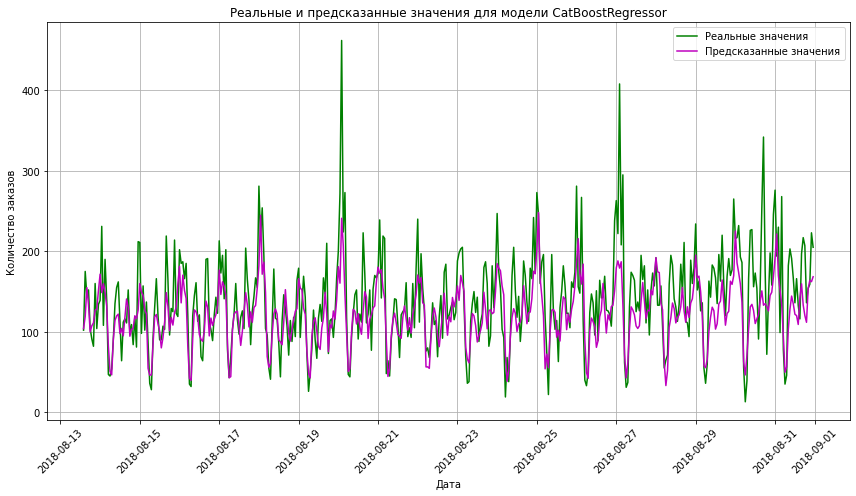

In [60]:
# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.plot(y_test_cbr.index, y_test_cbr, 'g-', label='Реальные значения')  
plt.plot(y_test_cbr.index, y_pred_cbr, 'm-', label='Предсказанные значения') 
plt.title('Реальные и предсказанные значения для модели CatBoostRegressor')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

По графику выше видно, что модель CatBoostRegressor склонна недооценивать значения, однако даже при этом, модель удовлетворяет требованию, что значение RMSE на тестовой выборке должно быть не больше 48.

Итак, в данном шаге мы провели анализ нескольких моделей машинного обучения. Мы сравнили пять моделей и составили рейтинг точности моделей: Linear Regression, LightGBM, CatBoostRegressor, DecisionTreeRegressor и RandomForestRegressor по следующим критериям: метрика RMSE, полученная на обучающих данных с помощью кросс валидации, время обучения и время предсказания.  
   
Мы наблюдаем, что Linear Regression имеет высокое значение RMSE, что делает её непригодной для данной задачи из-за низкой точности предсказаний. LightGBM показала хорошие результаты с более низким RMSE по сравнению с линейной регрессией, но её время обучения значительно выше, что может быть проблемой при работе с большими данными. CatBoostRegressor продемонстрировал низкий RMSE, хорошее качество предсказаний и быстрое время обучения и предсказания, что делает её наиболее эффективной моделью по качеству и скорости. DecisionTreeRegressor имеет более высокое RMSE, но её время обучения и предсказания минимально, что делает её подходящей для задач с ограничениями по времени. RandomForestRegressor показал хорошие результаты по качеству предсказаний, но время обучения оказалось выше, чем у CatBoost и DecisionTree, что снижает его эффективность.

Согласно этому рейтингу, лучшей моделью стала CatBoostRegressor. Мы также проверили ее работу на тестовых данных. Результат предсказания на тестовой выборке для модели CatBoostRegressor составил 42.92, что укладывается в установленные нам требования, что значение RMSE не должно превышать 48. После обучения модели CatBoostRegressor, также был построен график, на котором сравнивались реальные и предсказанные значения. По графику видно, что модель склонна немного недооценивать значения.

## Итоговый вывод

В данной работе мы провели полный цикл анализа и моделирования временного ряда данных, что включало подготовку данных, анализ сезонных и трендовых компонентов, а также обучение нескольких моделей машинного обучения с выбором лучшей их них для предсказания количества заказов такси.

На начальном этапе данные были приведены в формат, пригодный для анализа временного ряда. Датасет, состоящий из столбцов datetime и num_orders, был преобразован: столбец datetime был изменен на тип datetime64, а затем установлен в качестве индекса. После этих преобразований данные приняли вид временного ряда с записью каждые 10 минут, охватывающего период с марта по август 2018 года. Мы проверили монотонность временного ряда, убедившись, что данные расположены в хронологическом порядке, и выполнили ресемплирование с интервалом в один час, суммируя значения заказов в каждой группе. Этот шаг позволил нам подготовить датасет для дальнейшего анализа и моделирования.

Для более глубокого понимания структуры данных мы проанализировали компоненты временного ряда: тренд, сезонность и остатки. Сначала был выявлен общий тренд на увеличение количества заказов, что может свидетельствовать об общем росте спроса на услуги такси. В ходе анализа сезонности были обнаружены четкие циклы в недельной и суточной активности, с пиками в утренние и вечерние часы и колебаниями спроса по дням недели. Этот анализ подтвердил, что потребность в такси следует закономерностям повседневной жизни и зависит от ритма будней и выходных. 

В следующей части работы мы приступили к обучению нескольких моделей, настраивая их для достижения наилучшего качества предсказаний. Были протестированы модели LightGBM, LinearRegression, DecisionTreeRegressor, CatBoostRegressor и RandomForestRegressor. В ходе настройки мы использовали кросс-валидацию, чтобы найти оптимальные гиперпараметры для каждой модели. Мы оценивали точность с помощью метрики RMSE, а также учитывали время обучения и время предсказания на тестовой выборке. Это позволило нам составить рейтинг моделей по их эффективности.

Анализ результатов показал, что модель линейной регрессии продемонстрировала низкую точность, что делает её менее пригодной для данной задачи. LightGBM показала хорошие результаты, однако время обучения было относительно высоким. CatBoostRegressor продемонстрировала лучшие показатели по качеству предсказаний, а также по скорости обучения и предсказания, что делает её наиболее эффективной моделью. DecisionTreeRegressor имела минимальное время обучения и предсказания, но более высокое значение RMSE, подходя для задач, требующих быстрой результативности. RandomForestRegressor, хоть и показал высокую точность, оказался менее эффективен по времени обучения.

Лучшей моделью мы выбрали CatBoostRegressor, которая обеспечила значение RMSE на тестовой выборке 42.92, что укладывается в установленное требование (RMSE < 48). На итоговом графике сравнили предсказанные и реальные значения и заметили, что модель несколько недооценивает значения, но сохраняет общую динамику. Этот результат свидетельствует о том, что наша модель машинного обучения может использоваться для прогнозирования количества заказов такси, что позволит более эффективно привлекать водителей в периоды повышенного спроса, обеспечивая их своевременное присутствие в нужные моменты, а также более точно планировать ресурсы, оптимизировать обслуживание и улучшить управление бизнесом.